# **AI Developer Productivity & Stress Index (AIDPSI) Analysis**

This notebook analyzes software developer performance and well-being using AI-assisted tools. Two predictive models are implemented:

   1. Stress Prediction Model: predicts individual developer stress levels based on workload, cognitive load, lifestyle, and AI usage metrics.
   2. Productivity Prediction Model: classifies developer productivity into Low, Medium, or High based on coding activity, task efficiency, and behavioral metrics.

## **Stage 1: Retrieving and loading the dataset**

As the first step, we load our dataset and provide some initial overview on the data through shape, columns and info methods.

In [3]:
import pandas as pd
import numpy as np

file_path = 'AI_Developer_Performance.csv';
data = pd.read_csv(file_path);
print(data.head());

   Hours_Coding  Lines_of_Code  Bugs_Found  Bugs_Fixed  AI_Usage_Hours  \
0             7            416           9           7               6   
1             4            269          16          13               5   
2            11            439           3           0               2   
3             8            472          15           9               4   
4             5            265          19          16               5   

   Sleep_Hours  Cognitive_Load  Task_Success_Rate  Coffee_Intake  \
0          5.9              92                 34              7   
1          5.1              85                 36              2   
2          6.2              38                 79              2   
3          4.2              26                 94              5   
4          8.1              82                 33              6   

   Stress_Level  Task_Duration_Hours  Commits  Errors  
0            99                 10.5       20       3  
1           100                  9

In [5]:
print(f"Shape of the data (rows, columns): {data.shape}")
print(f"Columns in data: {list(data.columns)}\n")

data.info()


Shape of the data (rows, columns): (1000, 13)
Columns in data: ['Hours_Coding', 'Lines_of_Code', 'Bugs_Found', 'Bugs_Fixed', 'AI_Usage_Hours', 'Sleep_Hours', 'Cognitive_Load', 'Task_Success_Rate', 'Coffee_Intake', 'Stress_Level', 'Task_Duration_Hours', 'Commits', 'Errors']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Hours_Coding         1000 non-null   int64  
 1   Lines_of_Code        1000 non-null   int64  
 2   Bugs_Found           1000 non-null   int64  
 3   Bugs_Fixed           1000 non-null   int64  
 4   AI_Usage_Hours       1000 non-null   int64  
 5   Sleep_Hours          1000 non-null   float64
 6   Cognitive_Load       1000 non-null   int64  
 7   Task_Success_Rate    1000 non-null   int64  
 8   Coffee_Intake        1000 non-null   int64  
 9   Stress_Level         1000 non-null   int64  
 10  Task_Duration_

#### Initial Data Quality Assessment

- All features are numerical, so no categorical encoding is needed.
- No missing values were found.
- The dataset is structured and ready for preprocessing.

This confirms the data is complete and suitable analysis.

## **Stage 2: Data Preparation**
In this section, we prepare the dataset for stress level prediction. 
This includes:
1. Data Cleansing : removing duplicates, missing or invalid values.
2. Data Transformation : feature engineering and scaling.

### 2.1 Data Cleansing

In [6]:
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    df = data.drop_duplicates()
    print("Duplicates removed.")
else:
    print("No duplicates found.")

Number of duplicate rows: 0
No duplicates found.


In [7]:
missing_values = data.isnull().sum();
print(f'Number of missing values in each column:\n {missing_values}')

Number of missing values in each column:
 Hours_Coding           0
Lines_of_Code          0
Bugs_Found             0
Bugs_Fixed             0
AI_Usage_Hours         0
Sleep_Hours            0
Cognitive_Load         0
Task_Success_Rate      0
Coffee_Intake          0
Stress_Level           0
Task_Duration_Hours    0
Commits                0
Errors                 0
dtype: int64


No missing values were found in the dataset, indicating completeness
and suitability for modeling.


In [8]:
invalid_coding_hours = data[(data['Hours_Coding'] <= 0) | (data['Hours_Coding'] >= 24)].shape[0]
invalid_lines = data[data['Lines_of_Code'] < 0].shape[0]
invalid_bugs = data[data['Bugs_Found'] < 0].shape[0]
invalid_bugs_fixed = data[data['Bugs_Fixed'] < 0].shape[0]
invalid_sleep_hours = data[(data['Sleep_Hours'] <= 0) | (data['Sleep_Hours'] >= 24)].shape[0]
invalid_AI_hours = data[(data['AI_Usage_Hours'] < 0) | (data['AI_Usage_Hours'] > 24)].shape[0]
invalid_coffee = data[data['Coffee_Intake'] < 0].shape[0]
invalid_task_hours = data[(data['Task_Duration_Hours'] <= 0)].shape[0]

print(f"Invalid Coding Hours: {invalid_coding_hours}")
print(f"Invalid Lines of Code: {invalid_lines}")
print(f"Invalid Bugs Found: {invalid_bugs}")
print(f"Invalid Bugs Fixed: {invalid_bugs_fixed}")
print(f"Invalid Sleep Hours: {invalid_sleep_hours}")
print(f"Invalid AI Usage Hours: {invalid_AI_hours}")
print(f"Invalid Coffee Intake: {invalid_coffee}")
print(f"Invalid Task Duration Hours: {invalid_task_hours}")


Invalid Coding Hours: 0
Invalid Lines of Code: 0
Invalid Bugs Found: 0
Invalid Bugs Fixed: 0
Invalid Sleep Hours: 0
Invalid AI Usage Hours: 0
Invalid Coffee Intake: 0
Invalid Task Duration Hours: 0


All values are within reasonable ranges.
This confirms the dataset is clean and ready for feature engineering.


### 2.2 Feature Engineering

We create new features that may improve model performance.


In [9]:
data['Bug_Fix_Ratio'] = np.where(data['Bugs_Found'] > 0, data['Bugs_Fixed'] / data['Bugs_Found'], 0)
data['Bug_Fix_Ratio'] = data['Bug_Fix_Ratio'].round(2)
print(data[['Bugs_Fixed','Bugs_Found','Bug_Fix_Ratio']].head())

   Bugs_Fixed  Bugs_Found  Bug_Fix_Ratio
0           7           9           0.78
1          13          16           0.81
2           0           3           0.00
3           9          15           0.60
4          16          19           0.84


The Bug_Fix_Ratio measures how efficiently a developer fixes the bugs 
they encounter. A higher value indicates better debugging efficiency.


### 2.3 Selecting Features and Target 


In [71]:
features = ['Hours_Coding', 'Lines_of_Code', 'Bugs_Found', 'Bugs_Fixed','AI_Usage_Hours', 'Sleep_Hours', 
            'Cognitive_Load','Coffee_Intake', 'Task_Duration_Hours', 'Commits','Errors', 'Bug_Fix_Ratio']

target_stress = 'Stress_Level'

X = data[features]
Y = data[target_stress]

print(X.head())

   Hours_Coding  Lines_of_Code  Bugs_Found  Bugs_Fixed  AI_Usage_Hours  \
0             7            416           9           7               6   
1             4            269          16          13               5   
2            11            439           3           0               2   
3             8            472          15           9               4   
4             5            265          19          16               5   

   Sleep_Hours  Cognitive_Load  Coffee_Intake  Task_Duration_Hours  Commits  \
0          5.9              92              7                 10.5       20   
1          5.1              85              2                  9.5       17   
2          6.2              38              2                 18.3       35   
3          4.2              26              5                 12.6       28   
4          8.1              82              6                  7.0       25   

   Errors  Bug_Fix_Ratio  
0       3           0.78  
1       8           0.81  

### 2.4 Feature Scaling

Since input features have different scales, we standardize them 
using StandardScaler. This ensures that features contribute equally 
to the regression model and improves convergence for some algorithms.


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)
print(X_scaled.head());

Y_DF = pd.DataFrame(Y)

y_scaler = StandardScaler()
Y_scaled = y_scaler.fit_transform(Y_DF)

Y_scaled = pd.DataFrame(Y_scaled, columns=[target_stress])
print(Y_scaled.head())



   Hours_Coding  Lines_of_Code  Bugs_Found  Bugs_Fixed  AI_Usage_Hours  \
0      0.367442       0.317801   -0.151213   -0.027994        1.504257   
1     -0.582839      -0.463860    1.057110    1.069803        1.009273   
2      1.634484       0.440101   -1.186918   -1.308757       -0.475680   
3      0.684202       0.615576    0.884492    0.337939        0.514288   
4     -0.266079      -0.485129    1.574963    1.618702        1.009273   

   Sleep_Hours  Cognitive_Load  Coffee_Intake  Task_Duration_Hours   Commits  \
0    -0.393242        1.611785       1.551432             0.300489  0.253613   
1    -0.949258        1.290044      -0.584350             0.133542 -0.023358   
2    -0.184736       -0.870218      -0.584350             1.602683  1.638465   
3    -1.574775       -1.421774       0.697119             0.651080  0.992200   
4     1.135801        1.152155       1.124276            -0.283828  0.715230   

     Errors  Bug_Fix_Ratio  
0 -0.547598       0.572760  
1  1.225712     

### Summary of Data Preparation

- No missing or duplicate values.
- Created Bug_Fix_Ratio.
- Features and target separated and standardized.

Data is ready for analysis.

## **Stage 3: Exploratory Data Analysis (EDA)**

### 3.1 Descriptive Statistics

We begin by summarizing the central tendency, dispersion, and range 
of all features and the target variable Stress_Level. 
Descriptive statistics help identify potential outliers and understand 
overall variability in developer behavior.


In [12]:
desc_stats = data[features + [target_stress]].describe().T
desc_stats['variance'] = data[features + [target_stress]].var()
desc_stats['skewness'] = data[features + [target_stress]].skew()

desc_stats

,count,mean,std,min,25%,50%,75%,max,variance,skewness
Hours_Coding,1000.0,5.84000,3.158540,1.0,3.00,6.00,9.0000,11.0,9.976376,0.028137
Lines_of_Code,1000.0,356.23400,188.155350,26.0,209.50,332.00,480.5000,993.0,35402.435680,0.583264
Bugs_Found,1000.0,9.87600,5.796052,0.0,5.00,10.00,15.0000,19.0,33.594218,-0.092492
Bugs_Fixed,1000.0,7.15300,5.468226,0.0,2.00,7.00,12.0000,19.0,29.901492,0.160721
AI_Usage_Hours,1000.0,2.96100,2.021278,0.0,1.00,3.00,5.0000,6.0,4.085565,0.021206
Sleep_Hours,1000.0,6.46580,1.439529,4.0,5.20,6.40,7.7000,9.0,2.072243,0.062083
Cognitive_Load,1000.0,56.93300,21.767506,20.0,38.00,57.00,76.0000,94.0,473.824335,0.013710
Coffee_Intake,1000.0,3.36800,2.342234,0.0,1.00,3.00,5.0000,7.0,5.486062,0.058356
Task_Duration_Hours,1000.0,8.70010,5.992891,0.5,4.00,7.45,12.0000,27.5,35.914745,0.783649
Commits,1000.0,17.25300,10.836901,1.0,9.00,14.00,23.0000,50.0,117.438429,0.951804


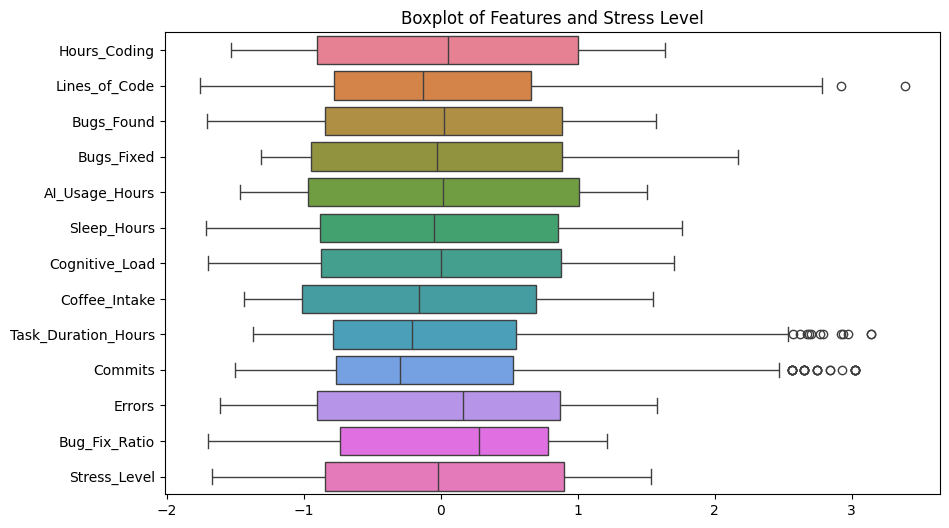

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

combined_scaled = pd.concat([X_scaled, Y_scaled], axis=1)

plt.figure(figsize=(10,6))
sns.boxplot(data=combined_scaled, orient='h')
plt.title('Boxplot of Features and Stress Level')
plt.show()



The boxplot shows the distribution of Stress Level after scaling. Stress levels have moderate spread with the median near the center, indicating most observations cluster around average stress, with some higher and lower cases. Outliers represent relative extremes, not errors.

Scaling X and Y was necessary because original features had different ranges, ensuring fair comparison.


The descriptive statistics provide insights such as:
- Mean and median values for working hours, sleep, cognitive load, and stress levels.
- Minimum and maximum values to spot extreme cases.
- Standard deviation to assess variability among developers.

### 3.2 Distribution Analysis

We visualize the distribution of key variables to understand patterns 
and skewness. This helps in detecting imbalances or unusual trends.


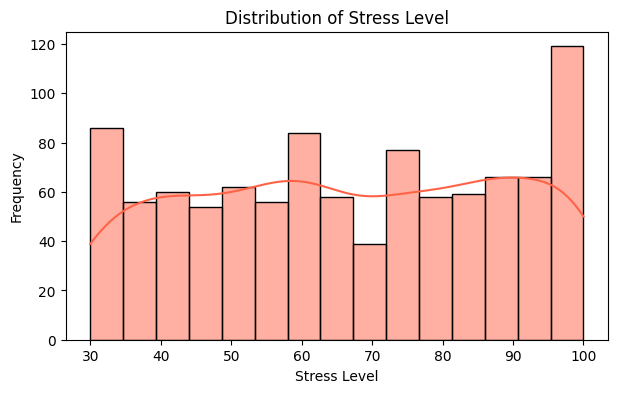

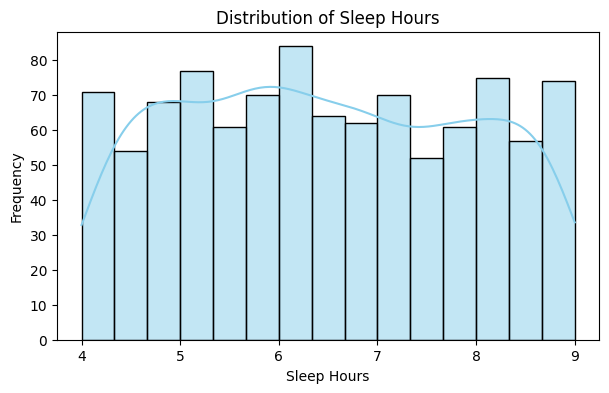

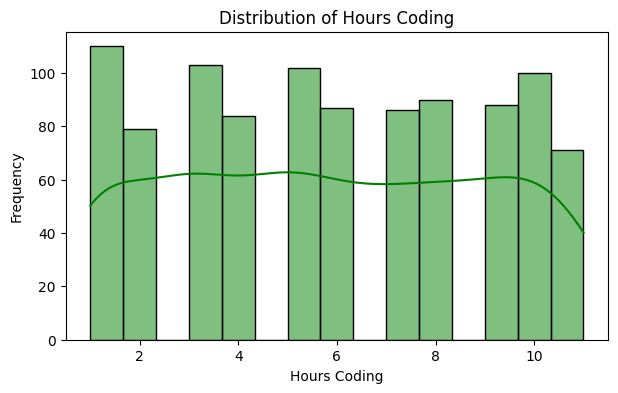

In [14]:
plt.figure(figsize=(7,4))
sns.histplot(data['Stress_Level'], bins=15, kde=True, color='Tomato')
plt.title('Distribution of Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Frequency')
plt.show()

print('\n')

plt.figure(figsize=(7,4))
sns.histplot(data['Sleep_Hours'], bins=15, kde=True, color='Skyblue')
plt.title('Distribution of Sleep Hours')
plt.xlabel('Sleep Hours')
plt.ylabel('Frequency')
plt.show()

print('\n')

plt.figure(figsize=(7,4))
sns.histplot(data['Hours_Coding'], bins=15, kde=True, color='green')
plt.title('Distribution of Hours Coding')
plt.xlabel('Hours Coding')
plt.ylabel('Frequency')
plt.show()

- Stress Level: Mostly uniform, with a spike at the high end showing a group under extreme stress.
- Sleep Hours: Uniformly spread between 4–9 hours, with 6 hours slightly more common.
- Coding Hours: Multimodal, indicating different patterns or groups of developers.

### 3.3 Relationship Analysis

We analyze relationships between stress levels and key features 
to identify potential predictors.


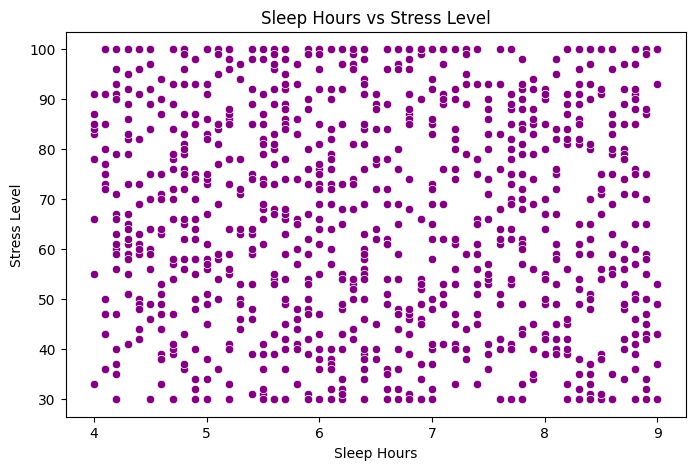

In [15]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Sleep_Hours',y='Stress_Level',data=data,color='purple')
plt.title('Sleep Hours vs Stress Level')
plt.xlabel('Sleep Hours')
plt.ylabel('Stress Level')
plt.show()

The scatter plot shows a wide dispersion of stress levels across all sleep durations (4–9 hours). There is no clear linear or nonlinear trend between sleep hours and stress level. High and low stress values appear at nearly all sleep durations, indicating a weak or negligible relationship between the two variables.

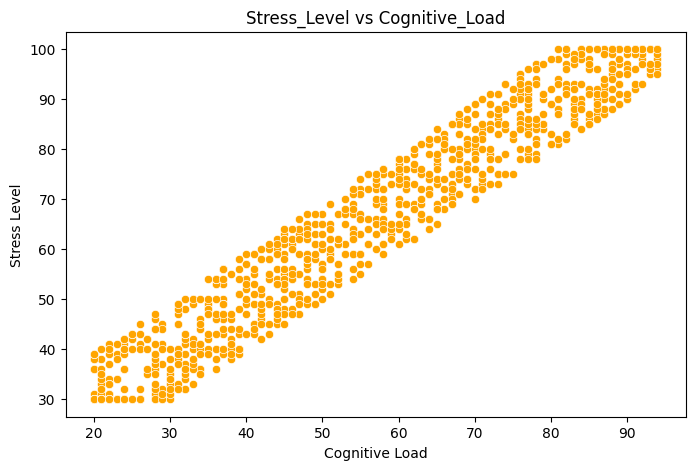

In [16]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Cognitive_Load', y='Stress_Level', data=data, color='orange')
plt.title('Stress_Level vs Cognitive_Load')
plt.xlabel('Cognitive Load')
plt.ylabel('Stress Level')
plt.show()

The scatter plot shows a strong positive relationship between cognitive load and stress level. As cognitive load increases, stress levels also rise in a nearly linear pattern, indicating that higher mental demands are associated with higher stress.

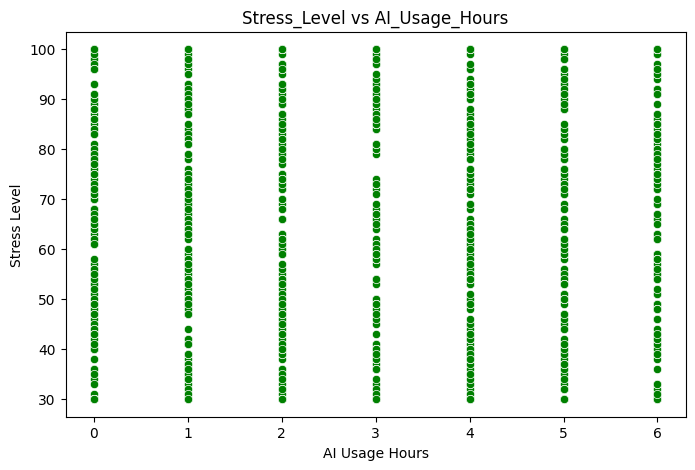

In [17]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='AI_Usage_Hours', y='Stress_Level', data=data, color='green')
plt.title('Stress_Level vs AI_Usage_Hours')
plt.xlabel('AI Usage Hours')
plt.ylabel('Stress Level')
plt.show()

The scatter plot shows stress levels (≈30–100) across AI usage hours (0–6). Stress values are widely spread at every usage level, indicating no clear trend or strong correlation between AI usage hours and stress.

### 3.4 Correlation Analysis

We compute pairwise correlations to identify the strongest predictors 
of stress and detect multicollinearity among features.


In [18]:
corr_matrix = data[features + [target_stress]].corr().round(2)
display(corr_matrix)

,Hours_Coding,Lines_of_Code,Bugs_Found,Bugs_Fixed,AI_Usage_Hours,Sleep_Hours,Cognitive_Load,Coffee_Intake,Task_Duration_Hours,Commits,Errors,Bug_Fix_Ratio,Stress_Level
Hours_Coding,1.00,0.81,0.04,0.02,-0.00,0.00,-0.02,-0.05,0.78,0.70,0.02,0.03,-0.01
Lines_of_Code,0.81,1.00,0.04,0.02,0.29,-0.03,-0.04,-0.02,0.64,0.62,0.04,0.01,-0.04
Bugs_Found,0.04,0.04,1.00,0.94,-0.01,-0.01,-0.02,0.02,0.02,0.04,-0.02,0.70,-0.02
Bugs_Fixed,0.02,0.02,0.94,1.00,-0.02,-0.01,-0.03,0.01,-0.01,0.02,-0.04,0.82,-0.03
AI_Usage_Hours,-0.00,0.29,-0.01,-0.02,1.00,-0.03,-0.01,-0.01,-0.01,0.17,0.04,-0.04,-0.03
Sleep_Hours,0.00,-0.03,-0.01,-0.01,-0.03,1.00,-0.05,0.01,-0.03,0.04,-0.04,-0.01,-0.05
Cognitive_Load,-0.02,-0.04,-0.02,-0.03,-0.01,-0.05,1.00,0.05,-0.02,-0.01,-0.03,-0.02,0.97
Coffee_Intake,-0.05,-0.02,0.02,0.01,-0.01,0.01,0.05,1.00,0.00,-0.08,-0.03,0.02,0.04
Task_Duration_Hours,0.78,0.64,0.02,-0.01,-0.01,-0.03,-0.02,0.00,1.00,0.53,0.04,-0.00,-0.01
Commits,0.70,0.62,0.04,0.02,0.17,0.04,-0.01,-0.08,0.53,1.00,0.01,0.01,-0.01


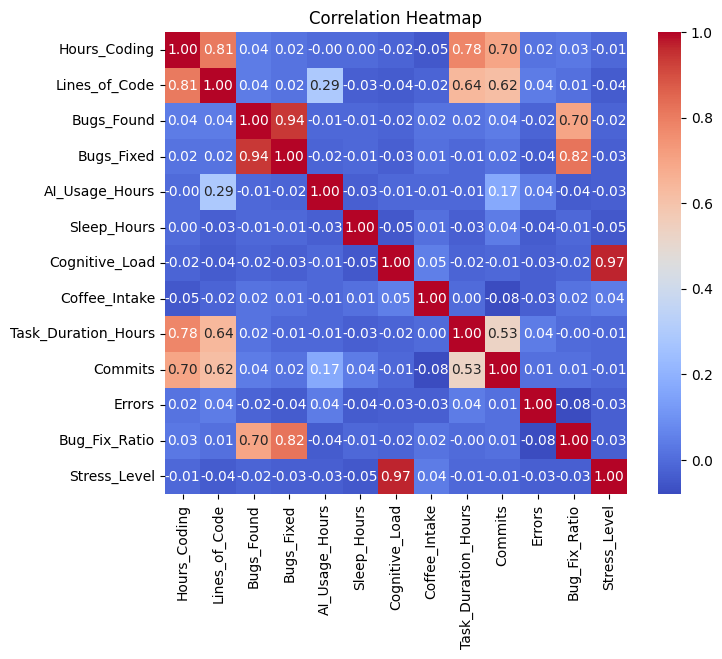

In [19]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows stress level is strongly linked to cognitive load, with higher mental workload increasing stress. Most other factors, like AI usage, sleep, coding time, commits, and errors, show weak or no correlation.

Strong relationships also appear between hours coding and lines of code, and between bugs found and bugs fixed. Overall, stress is mainly driven by cognitive demands.

**EDA Summary**

- Stress_Level varies moderately, suitable for regression.
- Sleep_Hours and Cognitive_Load strongly relate to stress.
- Workload features show expected correlations.
- No major anomalies affect modeling.

These insights inform feature selection and model choice.

## **Stage 4: Stress Level Prediction Model**

#### 4.1 Model Selection

The target variable Stress_Level is continuous, therefore Linear Regression 
is selected as the appropriate modeling technique.
Linear Regression models the relationship between stress levels and multiple 
independent variables by fitting a linear equation to the observed data.


#### 4.2 Train-test split

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
print("Training samples: ", X_train.shape[0])
print("Testing samples: ", X_test.shape[0])

Training samples:  800
Testing samples:  200


#### 4.3 Model Training

The Linear Regression model is trained using the training dataset 
to learn the relationship between input features and stress levels.


In [21]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression();

LR_model.fit(X_train, Y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


#### 4.4 Model interpretation 

In [22]:
coefficients = pd.DataFrame({'Feature': features,'Coefficient': LR_model.coef_}).sort_values(by='Coefficient', ascending=False)

print("Intercept:", LR_model.intercept_)
display(coefficients)

Intercept: 66.45306959783275


,Feature,Coefficient
6,Cognitive_Load,21.315950
3,Bugs_Fixed,1.439008
8,Task_Duration_Hours,0.146344
0,Hours_Coding,0.101971
1,Lines_of_Code,-0.045380
7,Coffee_Intake,-0.062764
5,Sleep_Hours,-0.135434
10,Errors,-0.175496
9,Commits,-0.236272
4,AI_Usage_Hours,-0.264092


The table shows how each feature affects Stress_Level in the linear regression model:

- Positive coefficients increase stress; negative coefficients decrease stress.
- Cognitive_Load (21.32) has the largest impact.
- Bugs_Fixed (1.44) and Task_Duration_Hours (0.15) slightly increase stress.
- Bug_Fix_Ratio (-0.76) and Bugs_Found (-0.85) reduce stress.
- Sleep_Hours and Coffee_Intake have smaller negative effects.

The intercept represents stress when all features are zero.

#### 4.5 Model Prediction

In [23]:
Y_predicted = LR_model.predict(X_test)

#### 4.6 Actual vs Predicted Stress_Level


In [24]:
results_table = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(Y_test).reset_index(drop=True),
    pd.DataFrame(Y_predicted, columns=['Predicted_Stress']).reset_index(drop=True)
], axis=1)

results_table['Residuals'] = results_table['Stress_Level'] - results_table['Predicted_Stress']

results_table

,Hours_Coding,Lines_of_Code,Bugs_Found,Bugs_Fixed,AI_Usage_Hours,Sleep_Hours,Cognitive_Load,Coffee_Intake,Task_Duration_Hours,Commits,Errors,Bug_Fix_Ratio,Stress_Level,Predicted_Stress,Residuals
0,-0.899599,-0.649969,-0.841683,-0.759859,-0.475680,1.344307,0.278858,0.697119,-1.168652,-1.131240,-0.192936,0.048654,81,71.948774,9.051226
1,-1.216360,-0.543621,-0.841683,-1.125791,1.504257,0.093272,1.336007,0.269963,-1.068483,-0.484975,1.225712,-1.116024,100,94.087882,5.912118
2,-0.266079,-0.479812,0.539257,0.337939,0.514288,-0.045732,1.244081,-0.157194,-0.367302,-0.300328,-0.902260,0.310707,84,92.815605,-8.815605
3,-0.266079,-1.149806,-1.186918,-1.308757,-1.465648,1.135801,0.140969,-0.157194,0.500827,0.253613,-0.547598,-1.698363,76,70.246028,5.753972
4,0.684202,2.412863,-1.359536,-1.308757,1.504257,1.066299,-0.640403,0.697119,0.283795,1.176847,0.871050,-1.698363,55,52.344659,2.655341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.317723,2.705321,1.057110,1.435736,1.009273,-1.088261,0.324821,0.269963,-0.484165,-0.208005,1.580374,1.038631,64,73.335581,-9.335581
196,-1.533120,-1.490121,-1.014301,-0.576892,-0.970664,-0.462744,0.922340,-1.011506,-1.285515,-1.408210,-1.611584,1.213333,83,85.946190,-2.946190
197,1.634484,0.759146,1.574963,1.069803,1.009273,-1.644277,0.554636,-0.584350,1.819715,-0.115681,-0.192936,0.281590,80,78.717905,1.282095
198,0.684202,-0.096958,1.057110,1.618702,1.504257,-1.505273,1.703711,0.697119,-0.651113,1.915435,-0.902260,1.213333,95,102.729952,-7.729952


The table shows test set results: features, actual Stress_Level, predicted Stress, and residuals. Positive residuals mean underestimation, negative means overestimation. This helps assess model performance.

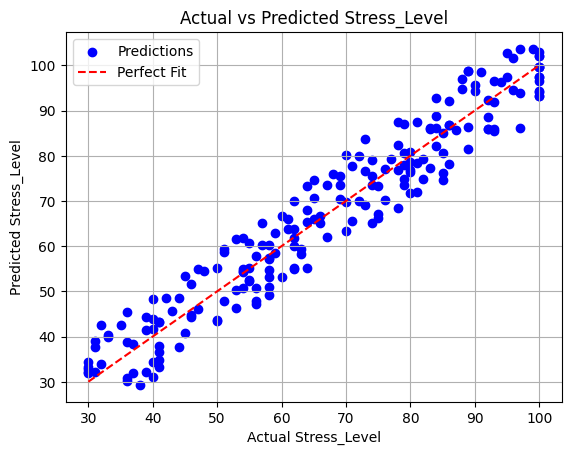

In [25]:
plt.scatter(Y_test, Y_predicted, color='blue', label='Predictions')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 
         color='red', linestyle='--', label='Perfect Fit')
plt.xlabel("Actual Stress_Level")
plt.ylabel("Predicted Stress_Level")
plt.title("Actual vs Predicted Stress_Level")
plt.legend()
plt.grid(True)
plt.show()


The scatter plot compares predicted vs actual stress. The red line shows perfect predictions. Most points are close to the line, with small deviations and randomly distributed residuals, indicating good model performance.

#### 4.7 Model Evaluation
The Linear Regression model is evaluated using MAE, RMSE and R-square.
These metrics confirm the model’s accuracy and reliability.

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(Y_test, Y_predicted)
rmse = np.sqrt(mean_squared_error(Y_test, Y_predicted))
r2 = r2_score(Y_test, Y_predicted)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 4.75
RMSE: 5.56
R² Score: 0.93


- MAE = 4.75: Predictions differ from actual stress by about 4.75 units on average.
- RMSE = 5.56: Larger errors are limited, showing reliable predictions.
- R² = 0.93: The model explains 93% of stress variability.

These evaluation metrics confirm that the Linear Regression model provides reliable stress predictions and offers interpretable insights into how workload and lifestyle factors influence developer stress.


#### 4.8 Prediction Example 

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

new_data = pd.DataFrame({
    'Hours_Coding': [6],
    'Lines_of_Code': [350],
    'Bugs_Found': [10],
    'Bugs_Fixed': [7],
    'AI_Usage_Hours': [3],
    'Sleep_Hours': [6.5],
    'Cognitive_Load': [57],
    'Coffee_Intake': [3],
    'Task_Duration_Hours': [8],
    'Commits': [17],
    'Errors': [5],
    'Bug_Fix_Ratio': [0.7]
})

new_data = new_data[features]

scaler = StandardScaler()
scaler.fit(X)

new_data_scaled = pd.DataFrame(scaler.transform(new_data), columns=features)

predicted_stress = LR_model.predict(new_data_scaled)
print(f"Predicted Stress Level: {predicted_stress[0]:.2f}")


Predicted Stress Level: 66.17


 ##  **Stage 5: Productivity Classification** 
 The goal is to categorize developers’ productivity into levels (High, Medium, Low) based on their task performance. A decision tree classifier is applied to predict these categories using workload, coding, and lifestyle features. Model evaluation uses metrics such as accuracy, precision, recall, and F1-score to assess how well the model classifies productivity levels.

#### 5.1 Defining the target variable

We convert the continuous Task_Success_Rate into categorical productivity levels.

In [36]:
def productivity_label(x):
    if x>70:
        return 'High'
    elif x>=40:
        return 'Medium'
    else:
        return 'Low'

data['Productivity_Level'] = data['Task_Success_Rate'].apply(productivity_label);
data.head()

,Hours_Coding,Lines_of_Code,Bugs_Found,Bugs_Fixed,AI_Usage_Hours,Sleep_Hours,Cognitive_Load,Task_Success_Rate,Coffee_Intake,Stress_Level,Task_Duration_Hours,Commits,Errors,Bug_Fix_Ratio,Productivity_Level
0,7,416,9,7,6,5.9,92,34,7,99,10.5,20,3,0.78,Low
1,4,269,16,13,5,5.1,85,36,2,100,9.5,17,8,0.81,Low
2,11,439,3,0,2,6.2,38,79,2,55,18.3,35,2,0.00,High
3,8,472,15,9,4,4.2,26,94,5,30,12.6,28,4,0.60,High
4,5,265,19,16,5,8.1,82,33,6,82,7.0,25,9,0.84,Low


In [35]:
data['Productivity_Level'].value_counts()

Productivity_Level
Medium    407
High      309
Low       284
Name: count, dtype: int64

#### 5.2 Selecting Features and Target

In [74]:
X2 = data[features]
Y2 = data['Productivity_Level']

#### 5.3 Train-Test Split

In [75]:
from sklearn.model_selection import train_test_split

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42, stratify=Y2)


#### 5.4 Feature Scaling

In [76]:
scaler_2 = StandardScaler()
X2_train_scaled = scaler_2.fit_transform(X2_train)
X2_test_scaled = scaler_2.transform(X2_test)

#### 5.5 Training the Decision Tree Classifier

In [77]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt_model = DecisionTreeClassifier(random_state=42,max_depth=5)
dt_model.fit(X2_train_scaled,Y2_train)


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

#### 5.6 Plotting Decision Tree

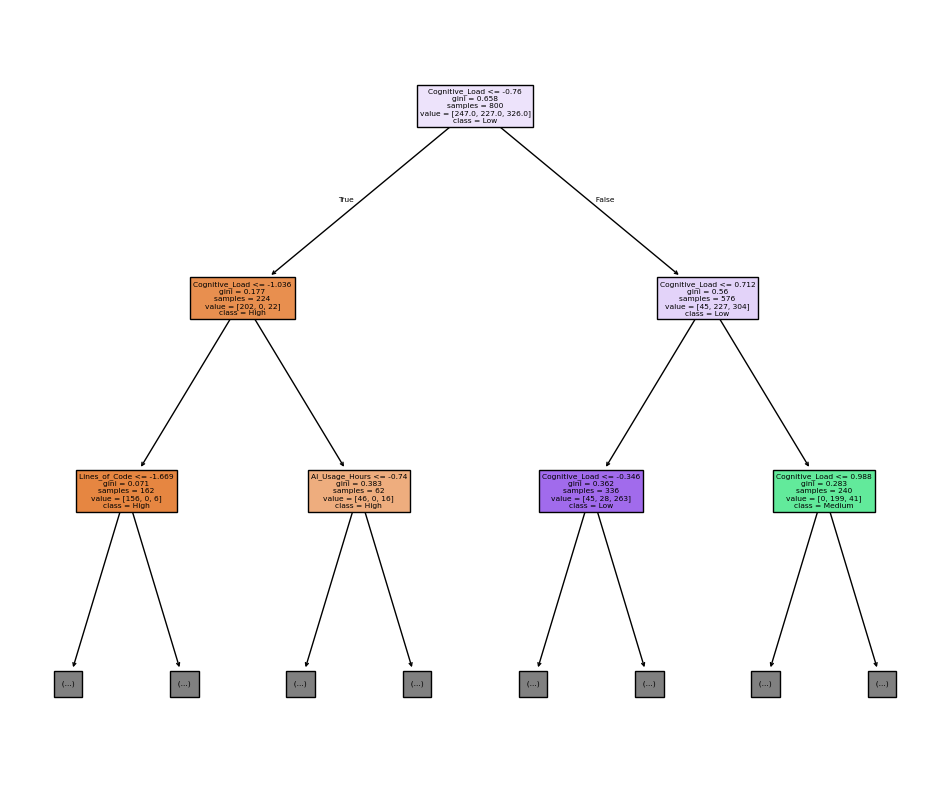

In [82]:
plt.figure(figsize=(12,10))
plot_tree(dt_model, feature_names=features, class_names=['High','Medium','Low'],filled=True,max_depth=2)
plt.show()

In [80]:
import pandas as pd

importance = pd.DataFrame({'Feature': features,'Importance': dt_model.feature_importances_}).sort_values(by='Importance', ascending=False)

print(importance)


                Feature  Importance
6        Cognitive_Load    0.828323
4        AI_Usage_Hours    0.130046
1         Lines_of_Code    0.017865
3            Bugs_Fixed    0.009389
5           Sleep_Hours    0.005922
7         Coffee_Intake    0.003259
8   Task_Duration_Hours    0.003250
2            Bugs_Found    0.001947
0          Hours_Coding    0.000000
9               Commits    0.000000
10               Errors    0.000000
11        Bug_Fix_Ratio    0.000000


The table shows feature importance from the decision tree for productivity classification:

- High impact: Cognitive_Load (0.828) – strongest predictor of productivity.
- Moderate impact: AI_Usage_Hours (0.13).
- Low impact: Lines_of_Code, Bugs_Fixed, Sleep_Hours, Coffee_Intake, Task_Duration_Hours.
- No impact: Hours_Coding, Commits, Errors, Bug_Fix_Ratio.
Conclusion: Productivity is mainly influenced by cognitive load, with a few secondary factors; several features do not contribute to classification decisions.

#### 5.7 Making predictions


In [83]:
Y2_predicted = dt_model.predict(X2_test_scaled)

#### 5.8 Model Evaluation

In [95]:
from sklearn.metrics import precision_score, recall_score, f1_score

classes = Y2_test.unique()
metrics = []

for c in classes:
    p = precision_score(Y2_test, Y2_predicted, labels=[c], average='macro')
    r = recall_score(Y2_test, Y2_predicted, labels=[c], average='macro')
    f1 = f1_score(Y2_test, Y2_predicted, labels=[c], average='macro')
    metrics.append([c, round(p, 2), round(r, 2), round(f1, 2)])

metrics_data = pd.DataFrame(metrics, columns=['Class', 'Precision', 'Recall', 'F1-score'])
display(metrics_data)



,Class,Precision,Recall,F1-score
0,Low,0.95,0.91,0.93
1,Medium,0.84,0.84,0.84
2,High,0.84,0.87,0.86


In [96]:
print("Accuracy:", accuracy_score(Y2_test, Y2_predicted))

Accuracy: 0.87


The model achieves an accuracy of 0.87 on the test set, indicating that it correctly classifies developer productivity in 87% of cases.

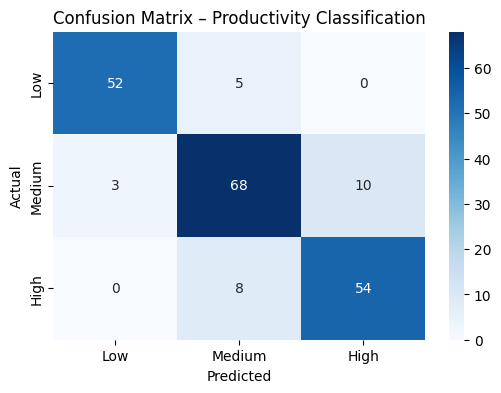

In [99]:
cm = confusion_matrix(Y2_test, Y2_predicted, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Productivity Classification')
plt.show()

The confusion matrix shows how well the productivity classification model predicted each class:

- Low productivity: 52 correctly predicted as Low, 5 misclassified as Medium, none as High.
- Medium productivity: 68 correctly predicted, 3 misclassified as Low, 10 as High.
- High productivity: 54 correctly predicted, 8 misclassified as Medium, none as Low.


#### 5.9 Prediction example

In [105]:
new_data = pd.DataFrame({
    'Hours_Coding': [6],
    'Lines_of_Code': [350],
    'Bugs_Found': [10],
    'Bugs_Fixed': [7],
    'AI_Usage_Hours': [3],
    'Sleep_Hours': [6.5],
    'Cognitive_Load': [57],
    'Coffee_Intake': [3],
    'Task_Duration_Hours': [8],
    'Commits': [17],
    'Errors': [5],
    'Bug_Fix_Ratio': [0.7]
})

scaler_3 = StandardScaler()
scaler_3.fit(X2_train)
new_data_scaled = scaler_3.transform(new_data)

predicted_productivity = dt_model.predict(new_data_scaled)
print(predicted_productivity[0])

Medium


#### 5.10 Interpretation

Productivity classification was performed by converting Task_Success_Rate into three categories: Low, Medium, and High. A Decision Tree classifier was trained using workload and behavioral features.

The model achieved reasonable classification accuracy, showing that developer productivity can be effectively categorized based on coding activity, cognitive load, and lifestyle factors. The confusion matrix indicates that most predictions fall into the correct productivity class, with some overlap between Medium and High productivity levels.

Feature importance analysis shows that factors such as Cognitive_Load, Bugs_Fixed, Sleep_Hours, and Coding Activity play a key role in determining productivity. These results align with expectations that both workload intensity and behavioral habits influence developer performance.

Detailed discussion and implications are presented in the final report.

## **Stage 6: GUIs and report**

Both are included in folder.